In [1]:
import time

import torch
import einops
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data.dataset import random_split
from torch.utils.data import DataLoader, TensorDataset

from taker import Model

Load the texts

In [2]:
run_id = 2
generated_texts_file_name = f'generated_texts-1.pth'
attn_inputs_file_name = f"/mnt/vol_b/nextness/attn_inputs-{run_id}.pth"
attn_act_file_name    = f"/mnt/vol_b/nextness/attn_activations-{run_id}.pth"
predictions_file_name = f"/mnt/vol_b/nextness/predictions-{run_id}.pth"

In [3]:
# Which layer(s)?
layers_to_skip = 15
layer_index    = 15 # 0 / 15 / 30
layer_index_mapped = (layer_index % layers_to_skip)

# Load texts
loaded_texts  = torch.load(generated_texts_file_name)
prompts = [i[0] for i in loaded_texts]
completions = [i[1] for i in loaded_texts]
full_texts = [i[0] + i[1] for i in loaded_texts]

# prompt len is roughly 150 characters

Load the model

In [4]:
# Generate activations if there are none
m = Model("mistralai/Mistral-7B-v0.1", dtype="nf4")
# m = Model(dtype="nf4")
m.do_activations["mlp_pre_out"] = False
m.do_activations["attn_pre_out"] = False


/home/ubuntu/taker/src/taker/model.py:175: UserWarning: Model mistralai/Mistral-7B-v0.1 not tested.
  warnings.warn( f"Model {model_repo} not tested." )


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

- Loaded mistralai/Mistral-7B-v0.1
 - Registered 32 Attention Layers


Get activations.
- Get the output of each MLP layer and save them
- Only save every "layers_to_skip"-th layer
- I.e: for layers_to_skip = 15, save layers 0, 15, and 30

In [5]:
from tqdm import tqdm

layers_to_skip = 15

attn_inputs = []
attn_act    = []
# Open the file once and append data in each iteration
with torch.no_grad():
    for text in tqdm(full_texts[0:300]):
        act = m.get_text_activations(text=text)
        attn_out = act[1]
        ff_out   = act[2]

        res = m.get_residual_stream(text_activations=act)

        # Take every 15th layer starting from the first one
        attn_inputs.append(res[0::layers_to_skip*2, :, :].to("cpu"))
        attn_act.append(attn_out[0::layers_to_skip, :, :].to("cpu"))


100%|██████████| 200/200 [00:42<00:00,  4.69it/s]


In [6]:
torch.save(attn_inputs, attn_inputs_file_name)
torch.save(attn_act, attn_act_file_name)

In [7]:
# Inspect text
for i, text in enumerate(loaded_texts[:5]):
    print("TEXTS: ", i )
    print(text[0] + "//" +  text[1][:50])
print("...")

TEXTS:  0
The Casa de la Cultura is located in the center of Fuengirola and is a building where of all kinds cultural activities are taken place.
On the ground //ﬂoor of the building there is the tourist oﬃce, wh
TEXTS:  1
Au revoir, Nexus 5! Google is no longer officially selling its 2013 champion
The end of an era has come - Google has officially stopped selling the Ne//exus 5 through the Google Store. The Nexus 5, whic
TEXTS:  2
Oxycodone Dosage
An opioid pain medication, oxycodone is used to treat moderate to severe pain. Oxycodone is taken orally and is available in capsule,// tablet, and liquid forms. Oxycodone is also avail
TEXTS:  3
Cambridge clinched their first Varsity win since 2009 as they beat Oxford in a highly entertaining match at Twickenham.
A late try from Rory Triniman // and a conversion from Will Beer secured a 26-19 w
TEXTS:  4
Viagra is one of various penis extension things available today. This thing survey article will talk about how the tantamount to can be no

Define predictor model
- it is a simple single-layer transformer model
- I think it likely has ATTN + MLP but unsure 
- Output from running the model is the final activation from the final token 
- I.e: [n_texts, n_tokens, d_model] -> [n_texts, -1, d_model]

In [8]:
# Takes in batch, seq_len, features
class CustomTransformerModel(nn.Module):
    def __init__(self, input_size, output_size):
        super(CustomTransformerModel, self).__init__()
        self.embedding = nn.Linear(input_size, m.cfg.d_model) # Example embedding size
        self.transformer_block = nn.TransformerEncoderLayer(d_model=m.cfg.d_model, nhead=8)
        self.output_linear = nn.Linear(m.cfg.d_model, output_size)
        self.sigmoid = nn.Sigmoid()
        self.output_size = output_size

    def forward(self, x):
        x = self.embedding(x)
        x = x.permute(1, 0, 2) # Transformer expects [seq_len, batch, features]
        x = self.transformer_block(x)
        x = x.permute(1, 0, 2) # Revert permutation
        x = self.output_linear(x)
        x = x[:, -1, :] # Output is the final token
        return x

    # loss is ( x - y.mean() )**2


Define a method to train

In [9]:
# train
def train(data_in, data_out, model, criterion, num_epochs, save=False, learning_rate=0.001):
    # Create a complete dataset
    full_dataset = TensorDataset(data_in.to("cuda").float(), data_out.to("cuda").float())

    # Define the sizes for your training and validation sets
    total_size = len(full_dataset)
    train_size = int(0.8 * total_size)
    val_size = total_size - train_size

    # Split the dataset
    train_dataset, val_dataset = random_split(full_dataset, [train_size, val_size])

    # Create DataLoaders for both training and validation sets
    train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)
    val_dataloader = DataLoader(val_dataset, batch_size=500)  # No need to shuffle the validation data


    model.to("cuda")

    optimizer = optim.Adam(model.parameters(), lr=learning_rate)


    t0 = time.time()
    for epoch in range(num_epochs):
        # Training phase
        model.train()
        running_loss = 0.0
        for inputs, targets in train_dataloader:
            inputs, targets = inputs.to("cuda"), targets.to("cuda")

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * inputs.size(0)

        epoch_loss = running_loss / len(train_dataloader.dataset)
        # Validation phase
        model.eval()  # Set the model to evaluation mode
        running_loss = 0.0
        with torch.no_grad():  # No gradients need to be calculated
            for inputs, targets in val_dataloader:
                inputs, targets = inputs.to("cuda").float(), targets.to("cuda").float()
                outputs = model(inputs)

                loss = criterion(outputs, targets)
                running_loss += loss.item() * inputs.size(0)
        val_loss = running_loss / len(val_dataloader.dataset)

        print(f'Epoch [{epoch+1}/{num_epochs}], Training Loss: {epoch_loss:.8f}, Validation Loss: {val_loss:.8f}, t={time.time()-t0:.2f}s')

    if(save):
        # Ensure the model is in evaluation mode
        model.eval()

        predictions = []
        with torch.no_grad():  # No gradients needed for inference
            for inputs, _ in full_dataset:  # Assuming your dataset returns inputs and targets
                inputs = inputs.to('cuda').float().unsqueeze(0)

                # Get the model output
                outputs = model(inputs)


                predictions.append(outputs.cpu())

        # Concatenate all batches of predictions
        all_predictions = torch.stack(predictions, dim=0)

        # Save the tensor to a file
        torch.save(all_predictions, predictions_file_name)



In [10]:
# input is tokens 0-100
train_start = 0
train_end = 100

# output is mean of the tokens 100-120
average_start = 100
average_end = 120

# - activations is list of affective shape [text, layer, token, d_model]
# - act has shape [layer, token, d_model]
# we combine this to get the data for training:
# data_in.shape  == [n_texts, n_tokens=100, d_model] (100 "token" position inputs)
# data_out.shape == [n_texts, d_model] (1 "token" position output)
data_in  = torch.stack([act[layer_index_mapped, train_start:train_end, :] for act in attn_act])
data_out = torch.mean(
    torch.stack([
        act[layer_index_mapped, average_start:average_end, :] for act in attn_act
    ]),
    dim=1
)

# Define the loss and predictor model we will be using
criterion = nn.MSELoss()
model = CustomTransformerModel(input_size=m.cfg.d_model, output_size=m.cfg.d_model).to("cuda")

In [11]:
# train(data_in, data_out, model, criterion, num_epochs=100, save=True, learning_rate=0.0001)

## Do Analysis on Mikolaj Model

In [12]:
# res = torch.load(predictions_file_name)
# #res.shape

# full_dataset = TensorDataset(data_in.float(), data_out.float())

# n_items = len(full_dataset)
# dots = torch.zeros(n_items, n_items)
# dist = torch.zeros(n_items, n_items)

# o_mean = torch.zeros(n_items, len(res[0,0]))
# p_mean = torch.zeros_like(o_mean)
# for i, (inputs, output) in enumerate(full_dataset):  # Assuming your dataset returns inputs and targets
#     o_mean[i] = output
#     p_mean[i] = res[i,0]
# o_mean = o_mean.mean(dim=0)
# p_mean = o_mean.mean(dim=0)

# for i, (inputs, output) in enumerate(full_dataset):  # Assuming your dataset returns inputs and targets
#     for j, [prediction] in enumerate(res):
#         o_i = (output) #-o_mean)
#         p_j = (prediction) #-p_mean)
#         dist[i][j] = ((o_i - p_j)**2).sum().sqrt()

#         o_i /= o_i.norm()
#         p_j /= p_j.norm()

#         dots[i][j] = o_i.T @ p_j

#     #predictions.append(outputs.cpu())
#     #predictions.append(outputs.cpu())

# expected_dots = torch.zeros_like(dots)
# expected_dist = torch.zeros_like(dist)
# for i, (inputs, output) in enumerate(full_dataset):  # Assuming your dataset returns inputs and targets
#     for j, (_inputs, _output) in enumerate(full_dataset):
#         o_i = (output) #-o_mean)
#         p_j = (_output) #-p_mean)
#         expected_dist[i][j] = ((o_i - p_j)**2).sum().sqrt()

#         o_i /= o_i.norm()
#         p_j /= p_j.norm()

#         expected_dots[i][j] = o_i.T @ p_j

# import seaborn as sns
# import matplotlib.pyplot as plt

# fig, [ax1, ax2, ax3, ax4] = plt.subplots(nrows=1, ncols=4, figsize=(25,6))
# sns.heatmap(dots, square=True, ax=ax1, center=0.0)
# sns.heatmap(dist, square=True, ax=ax2)
# sns.heatmap(expected_dots, square=True, ax=ax3, center=0.0)
# sns.heatmap(expected_dist, square=True, ax=ax4)
# plt.show()

# Try LoRA head fine tuning

In [13]:
m.layers[layer_index]["attn"]

MistralSdpaAttention(
  (q_proj): Linear4bit(in_features=4096, out_features=4096, bias=False)
  (k_proj): Linear4bit(in_features=4096, out_features=1024, bias=False)
  (v_proj): Linear4bit(in_features=4096, out_features=1024, bias=False)
  (o_proj): Linear4bit(in_features=4096, out_features=4096, bias=False)
  (rotary_emb): MistralRotaryEmbedding()
)

In [80]:

# copied from transformers.models.llama.modeling_llama.LlamaSdpaAttention with Llama->Mistral
# TODO @Arthur no longer copied from LLama after static cache

import math

from transformers.models.mistral.modeling_mistral import MistralSdpaAttention

class Lora(nn.Module):
    def __init__(self, input_dim, output_dim, rank=4, dtype=torch.float16, use_bias=False):
        super(Lora, self).__init__()
        # Low-rank matrices A and B
        self.output_dim = output_dim
        self.A = nn.Parameter(torch.Tensor(rank, input_dim ).to(dtype=dtype))
        self.B = nn.Parameter(torch.Tensor(output_dim, rank).to(dtype=dtype))
        self._reset_parameters()

    def _reset_parameters(self):
        # Initialize A with Kaiming uniform and B with zeros
        nn.init.kaiming_uniform_(self.A, a=math.sqrt(5))
        nn.init.zeros_(self.B)

    def _A(self, x):
        return F.linear(input=x, weight=self.A)

    def _B(self, x):
        return F.linear(input=x, weight=self.B)

    def forward(self, x):
        # Compute only the LoRA adaptation without the standard linear component
        return self._B(self._A(x))

class LoraLinear(nn.Module):
    def __init__(self, linear, lora, use_bias=False):
        super(LoraLinear, self).__init__()
        # Low-rank matrices A and B
        self.linear = linear
        self.lora = lora
        self.bias = None
        if use_bias:
            self.bias = torch.nn.Parameter(torch.zeros([self.lora.output_dim]))

    def forward(self, x):
        y = self.linear(x) + self.lora(x)
        if self.bias is not None:
            return y + self.bias
        return y

class MistralSdpaLoraAttention(MistralSdpaAttention):
    def __init__(self, orig_attn, rank=4, dtype=torch.float16, use_bias=False):
        super(MistralSdpaLoraAttention, self).__init__(orig_attn.config)
        self.hidden_size = orig_attn.hidden_size
        self.num_heads   = orig_attn.num_heads
        self.head_dim    = orig_attn.head_dim
        self.rope_theta  = orig_attn.rope_theta
        self.is_causal   = True
        self.num_key_value_heads     = orig_attn.num_key_value_heads
        self.num_key_value_groups    = orig_attn.num_key_value_groups
        self.max_position_embeddings = orig_attn.max_position_embeddings
        self.attention_dropout       = orig_attn.attention_dropout

        if (self.head_dim * self.num_heads) != self.hidden_size:
            raise ValueError(
                f"hidden_size must be divisible by num_heads (got `hidden_size`: {self.hidden_size}"
                f" and `num_heads`: {self.num_heads})."
            )

        # Assuming orig_attn has the following attributes already initialized
        d_model = self.hidden_size
        d_kv = self.num_key_value_heads * self.head_dim
        n_kv = self.num_key_value_groups

        # load up modified attentions
        # self.q_proj_orig = orig_attn.q_proj  # Projects input to query space, size: [hidden_size, num_heads * head_dim]
        self.q_proj = LoraLinear(
            orig_attn.q_proj,
            Lora(d_model, d_model, rank=rank, dtype=dtype),
            use_bias=use_bias,
        )
        # self.k_proj_orig = orig_attn.k_proj  # Projects input to key space, size: [hidden_size, num_key_value_heads * head_dim]
        self.k_proj = LoraLinear(
            orig_attn.k_proj,
            Lora(d_model, d_kv, rank=rank, dtype=dtype),
            use_bias=use_bias,
        )
        # self.v_proj_orig = orig_attn.v_proj  # Projects input to value space, size: [hidden_size, num_key_value_heads * head_dim]
        self.v_proj = LoraLinear(
            orig_attn.v_proj,
            Lora(d_model, d_kv, rank=rank, dtype=dtype),
            use_bias=use_bias,
        )
        # self.o_proj_orig = orig_attn.o_proj  # Projects concatenated outputs back to hidden_size, size: [num_heads * head_dim, hidden_size]
        self.o_proj = LoraLinear(
            orig_attn.o_proj,
            Lora(d_model, d_model, rank=rank, dtype=dtype),
            use_bias=use_bias,
        )

        self.lora_list = [
            self.q_proj.lora,
            self.k_proj.lora,
            self.v_proj.lora,
            self.o_proj.lora,
        ]
        self.bias_list = []
        if use_bias:
            self.bias_list += [
                self.q_proj.bias,
                self.k_proj.bias,
                self.v_proj.bias,
                self.o_proj.bias,
            ]

        self.rotary_emb = orig_attn.rotary_emb

    def lora_params(self):
        for component in self.lora_list:
            for param in component.parameters():
                yield param
        for bias in self.bias_list:
            yield bias

class TunedConstant(nn.Module):
    def __init__(self, value):
        super(TunedConstant, self).__init__()
        self.value = nn.Parameter(value)

    def forward(self):
        return self.value

## Run Example with LoRA Attention + Tuned Constant

In [81]:
LN = m.layers[layer_index]["ln1"].to("cuda") # layer norm
attn = m.layers[layer_index]["attn"].to("cuda")
attn_lora = MistralSdpaLoraAttention(attn).to("cuda").float()
attn_mean_in = TunedConstant(torch.randn([1, attn.hidden_size])).to("cuda", dtype=torch.float16)

In [82]:
inpt = attn_inputs[0][layer_index_mapped].to("cuda")[None, ...]
act  = attn_act[0][layer_index_mapped]

new_inpt = torch.cat([inpt, attn_mean_in()[None, ...]], dim=1)
print(inpt.shape, new_inpt.shape)

test1 = attn(LN(inpt.float()))[0]
test2 = attn_lora(LN(inpt.float()))[0]
test3 = attn_lora(LN(new_inpt.float()))[0]

torch.Size([1, 260, 4096]) torch.Size([1, 261, 4096])


## Define Training Loop

In [124]:
# Load layer related things first:
LN = m.layers[layer_index]["ln1"].to("cuda")
attn = m.layers[layer_index]["attn"].to("cuda")

# The things we will be training
attn_lora    = MistralSdpaLoraAttention(attn, rank=4, use_bias=False).to("cuda")
attn_mean_in = TunedConstant(torch.randn([1, attn.hidden_size])).to("cuda", dtype=torch.float32)

# input is tokens 0-100
train_start = 0
train_end = 100

# output is mean of the tokens 100-120
average_start = 100
average_end   = 125

# - We want [ res 0:100, const ] -> [ attn 0:100, mean(attn 100:120) ]
act_in   = torch.stack([ LN( act[layer_index_mapped, train_start:train_end, :].to("cuda") ) for act in attn_inputs])
act_out  = torch.stack([     act[layer_index_mapped, train_start:train_end, :].to("cuda")   for act in attn_act])

act_mean_in  = attn_mean_in # defined above, TunedConstant input
act_mean_out = torch.mean(
    torch.stack([
        act[layer_index_mapped, average_start:average_end, :].to("cuda") for act in attn_act
    ]),
    dim=1
).unsqueeze(dim=1)

In [134]:
from tqdm import tqdm

# train
def new_train(num_epochs, save=False, learning_rate=0.001, vector_only=False):
    # Create a complete dataset
    full_dataset = TensorDataset(act_in.to("cuda"), act_out.to("cuda"), act_mean_out.to("cuda"))

    # Define the sizes for your training and validation sets
    total_size = len(full_dataset)
    train_size = int(0.99*total_size)
    val_size = total_size - train_size

    # Split the dataset
    train_dataset, val_dataset = random_split(full_dataset, [train_size, val_size])

    # Create DataLoaders for both training and validation sets
    train_dataloader = DataLoader(train_dataset, batch_size=1, shuffle=True)
    val_dataloader = DataLoader(val_dataset, batch_size=500)  # No need to shuffle the validation data

    model = attn_lora.float()
    params = [
        *attn_lora.lora_params(),
        *attn_mean_in.parameters()
    ]
    if vector_only:
        params = attn_mean_in.parameters()

    criterion = nn.MSELoss()
    optimizer = optim.Adam(params, lr=learning_rate)
    # optimizer_2 = optim.SGD(all_params, lr=0.0)

    def generate_inputs_targets(_in, _out, _mean_out):
        n_inputs = _in.shape[0]
        #_in_mean = torch.ones(n_inputs, 1, _in.shape[-1]).float()
        _in = _in.float().detach()
        _mean_in_part0 = _in.mean(dim=1).unsqueeze(dim=1).requires_grad_()
        _mean_in_part1 = attn_mean_in().expand(n_inputs, 1, -1)
        _mean_in = _mean_in_part0 + _mean_in_part1
        # _mean_in = _mean_in_part1
        _in = _in.requires_grad_()
        _out = _out.float().detach().requires_grad_()
        _mean_out = _mean_out.float().detach().requires_grad_()

        # dots = torch.zeros(_in.shape[1]+1, _in.shape[1]+1)
        # for i, xi in enumerate([*_in[0], _mean_in_part0[0,0]]):
        #     for j, xj in enumerate([*_in[0], _mean_in_part0[0,0]]):
        #         dots[i][j] = xi.T @ xj / (xi.norm()*xj.norm())
        # sns.heatmap(dots.detach().cpu())
        # plt.show()

        # dots = torch.zeros(_out.shape[1]+1, _out.shape[1]+1)
        # for i, xi in enumerate([*_out[0], _mean_out[0,0]]):
        #     for j, xj in enumerate([*_out[0], _mean_out[0,0]]):
        #         dots[i][j] = xi.T @ xj / (xi.norm()*xj.norm())
        # sns.heatmap(dots.detach().cpu())
        # plt.show()
        # raise Exception("sus")



        inputs   = torch.cat([_in,  _mean_in], dim=1)
        targets  = torch.cat([_out, _mean_out], dim=1)

        return inputs, targets


    def __test():
        model.eval()  # Set the model to evaluation mode
        attn_mean_in.eval()
        running_loss = 0.0
        with torch.no_grad():  # No gradients need to be calculated
            for _in, _out, _mean_out in val_dataloader:
                inputs, targets = generate_inputs_targets(_in, _out, _mean_out)

                outputs = model(inputs)[0]
                #loss = criterion(outputs[:, -1, :], targets[:, -1, :])
                # loss =   criterion(outputs[..., :-1, :], targets[..., :-1, :])*0.01 \
                #     + criterion(outputs[..., -1, :], targets[..., -1, :])
                loss = criterion(outputs[..., -1, :], targets[..., -1, :])

                running_loss += loss.item() * inputs.size(0)

        val_loss = running_loss / len(val_dataloader.dataset)
        return val_loss

    val_loss = __test()
    print(f'Initial Validation Loss: {val_loss:.8f}')

    t0 = time.time()
    for epoch in range(num_epochs):
        model.train()
        attn_mean_in.train()
        # Training phase
        running_loss = 0.0
        for _in, _out, _mean_out in train_dataloader:
            inputs, targets = generate_inputs_targets(_in, _out, _mean_out)

            optimizer.zero_grad()
            outputs = model(inputs)[0]
            # print(inputs[:, -3:, :])
            # print(outputs[:, -3:, :])
            # return
            # loss =   criterion(outputs[..., :-1, :], targets[..., :-1, :])*0.01 \
            #        + criterion(outputs[..., -1, :], targets[..., -1, :])
            loss = criterion(outputs[..., -1, :], targets[..., -1, :])
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * inputs.size(0)

        epoch_loss = running_loss / len(train_dataloader.dataset)
        # Validation phase
        val_loss = __test()

        print(f'Epoch [{epoch+1}/{num_epochs}], Training Loss: {epoch_loss:.8f}, Validation Loss: {val_loss:.8f}, t={time.time()-t0:.2f}s')

    if(save):
        # Ensure the model is in evaluation mode
        model.eval()

        predictions = []
        with torch.no_grad():  # No gradients needed for inference
            for _in, _out, _mean_out in DataLoader(full_dataset, batch_size=1):
                inputs, targets = generate_inputs_targets(_in, _out, _mean_out)
                outputs = model(inputs)[0]
                predictions.append(outputs.cpu()[..., -1, :])

        # Concatenate all batches of predictions
        all_predictions = torch.stack(predictions, dim=0)

        # Save the tensor to a file
        torch.save(all_predictions, predictions_file_name)

#new_train(num_epochs=100, save=True, learning_rate=1.0, vector_only=True)
#new_train(num_epochs=100, save=True, learning_rate=0.001)
new_train(num_epochs=100, save=True, learning_rate=0.0001)

Initial Validation Loss: 0.00000055
Epoch [1/100], Training Loss: 0.00000059, Validation Loss: 0.00000053, t=1.76s
Epoch [2/100], Training Loss: 0.00000056, Validation Loss: 0.00000057, t=3.43s
Epoch [3/100], Training Loss: 0.00000056, Validation Loss: 0.00000059, t=5.23s
Epoch [4/100], Training Loss: 0.00000059, Validation Loss: 0.00000054, t=6.94s
Epoch [5/100], Training Loss: 0.00000061, Validation Loss: 0.00000053, t=8.59s
Epoch [6/100], Training Loss: 0.00000057, Validation Loss: 0.00000058, t=10.33s
Epoch [7/100], Training Loss: 0.00000056, Validation Loss: 0.00000057, t=12.36s
Epoch [8/100], Training Loss: 0.00000061, Validation Loss: 0.00000053, t=14.44s
Epoch [9/100], Training Loss: 0.00000056, Validation Loss: 0.00000064, t=16.17s
Epoch [10/100], Training Loss: 0.00000059, Validation Loss: 0.00000054, t=17.87s
Epoch [11/100], Training Loss: 0.00000062, Validation Loss: 0.00000057, t=19.65s
Epoch [12/100], Training Loss: 0.00000056, Validation Loss: 0.00000053, t=21.40s
Epoch 

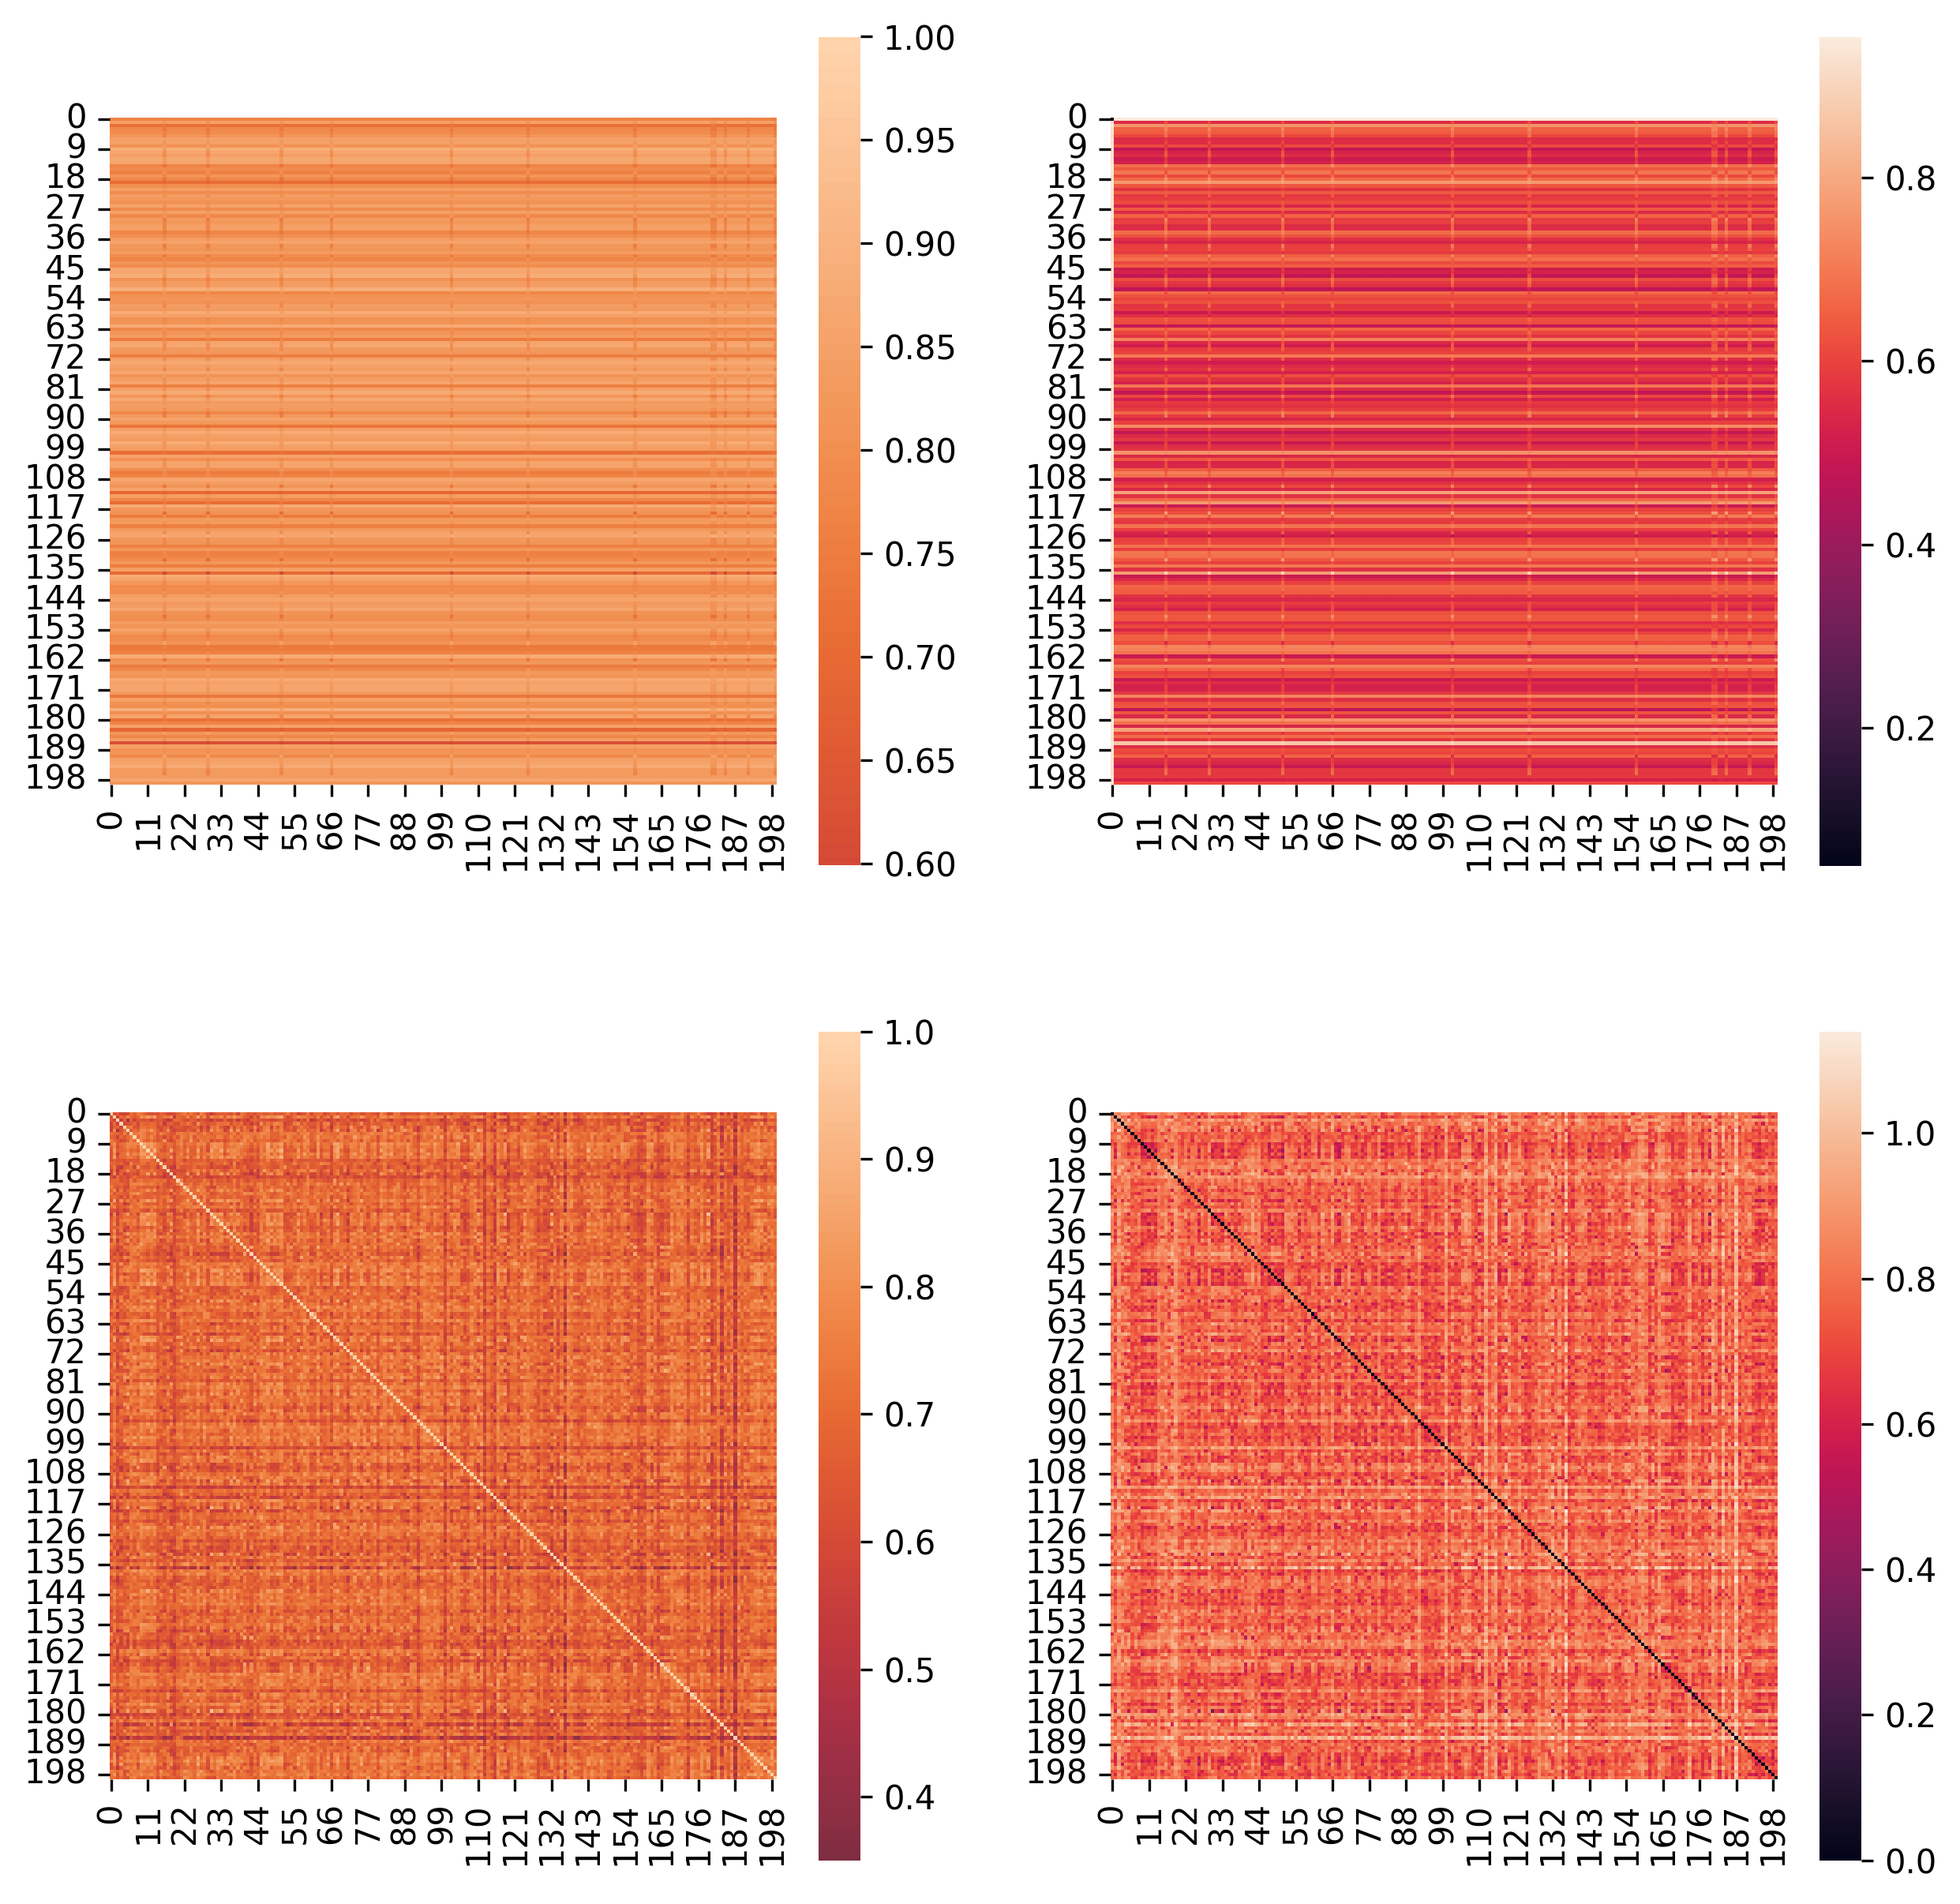

In [135]:
res = torch.load(predictions_file_name)
#res.shape

full_dataset = TensorDataset(data_in.float(), data_out.float())

n_items = len(full_dataset)
dots = torch.zeros(n_items, n_items)
dist = torch.zeros(n_items, n_items)

o_mean = torch.zeros(n_items, len(res[0,0]))
p_mean = torch.zeros_like(o_mean)
for i, (inputs, output) in enumerate(full_dataset):  # Assuming your dataset returns inputs and targets
    o_mean[i] = output
    p_mean[i] = res[i,0]
o_mean = o_mean.mean(dim=0)
p_mean = o_mean.mean(dim=0)

for i, (inputs, output) in enumerate(full_dataset):  # Assuming your dataset returns inputs and targets
    for j, [prediction] in enumerate(res):
        o_i = (output) #-o_mean)
        p_j = (prediction) #-p_mean)
        dist[i][j] = ((o_i - p_j)**2).sum().sqrt()

        o_i /= o_i.norm()
        p_j /= p_j.norm()

        dots[i][j] = o_i.T @ p_j

    #predictions.append(outputs.cpu())
    #predictions.append(outputs.cpu())

expected_dots = torch.zeros_like(dots)
expected_dist = torch.zeros_like(dist)
for i, (inputs, output) in enumerate(full_dataset):  # Assuming your dataset returns inputs and targets
    for j, (_inputs, _output) in enumerate(full_dataset):
        o_i = (output) #-o_mean)
        p_j = (_output) #-p_mean)
        expected_dist[i][j] = ((o_i - p_j)**2).sum().sqrt()

        o_i /= o_i.norm()
        p_j /= p_j.norm()

        expected_dots[i][j] = o_i.T @ p_j

import seaborn as sns
import matplotlib.pyplot as plt

fig, [[ax1, ax2], [ax3, ax4]] = plt.subplots(nrows=2, ncols=2, figsize=(10,10))
sns.heatmap(dots, square=True, ax=ax1, center=0.0, vmax=1.0)
sns.heatmap(dist, square=True, ax=ax2)
sns.heatmap(expected_dots, square=True, ax=ax3, center=0.0, vmax=1.0)
sns.heatmap(expected_dist, square=True, ax=ax4)
plt.show()

In [137]:
for p in attn_lora.parameters():
    print(p)

Parameter containing:
Parameter(Params4bit([[107],
            [118],
            [ 66],
            ...,
            [136],
            [ 52],
            [147]], device='cuda:0', dtype=torch.uint8))
Parameter containing:
tensor([[ 0.0050, -0.0026, -0.0002,  ...,  0.0098,  0.0138, -0.0055],
        [ 0.0129, -0.0044,  0.0116,  ..., -0.0100, -0.0191, -0.0057],
        [-0.0206, -0.0041, -0.0060,  ..., -0.0050, -0.0015, -0.0072],
        [-0.0143,  0.0069, -0.0111,  ..., -0.0138,  0.0063, -0.0164]],
       device='cuda:0', requires_grad=True)
Parameter containing:
tensor([[-0.0041,  0.0037, -0.0028,  0.0021],
        [ 0.0048, -0.0042,  0.0051,  0.0020],
        [-0.0116,  0.0058, -0.0059, -0.0021],
        ...,
        [ 0.0011, -0.0023,  0.0003,  0.0009],
        [-0.0023,  0.0033,  0.0021, -0.0005],
        [-0.0044, -0.0005, -0.0050, -0.0005]], device='cuda:0',
       requires_grad=True)
Parameter containing:
Parameter(Params4bit([[161],
            [134],
            [ 89],
       